In [1]:
!pip install geopandas pyproj shapely igraph

In [14]:
import json
import geopandas as gpd
from shapely.geometry import LineString
import igraph as ig
from shapely import geometry

# Step 1: Load raw GeoJSON
with open("filtered_output_2_small.geojson", "r") as f:
    data = json.load(f)

# Step 2: Clean the data by keeping only LineStrings with >= 2 points
valid_features = []
for feature in data['features']:
    coords = feature['geometry']['coordinates']
    if feature['geometry']['type'] == "LineString" and len(coords) >= 2:
        valid_features.append(feature)

# Step 3: Convert back to a cleaned GeoDataFrame
cleaned_data = {
    "type": "FeatureCollection",
    "features": valid_features
}

# Create geometries from cleaned coordinates
geometries = [LineString(feature["geometry"]["coordinates"]) for feature in valid_features]
gdf = gpd.GeoDataFrame(valid_features, geometry=geometries)
gdf.reset_index(drop=True, inplace=True)

# Step 4: Build intersection graph using igraph
edges = []
for i in range(len(gdf)):
    geom_i = gdf.geometry[i]
    for j in range(i + 1, len(gdf)):
        geom_j = gdf.geometry[j]
        try:
            if geom_i.intersects(geom_j):
                edges.append((i, j))
        except Exception as e:
            print(f"Error checking intersection between {i} and {j}: {e}")

graph = ig.Graph()
graph.add_vertices(len(gdf))
graph.add_edges(edges)

print(graph.summary())

IGRAPH U--- 2222 3274 -- 


In [3]:
import json
import geopandas as gpd
from shapely.geometry import LineString
import igraph as ig
import multiprocessing as mp

# Step 1: Load GeoJSON
with open("filtered_output_delhi.geojson", "r") as f:
    data = json.load(f)

# Step 2: Filter valid LineStrings
valid_features = []
for feature in data['features']:
    coords = feature['geometry']['coordinates']
    if feature['geometry']['type'] == "LineString" and len(coords) >= 2:
        valid_features.append(feature)

# Step 3: Create GeoDataFrame
geometries = [LineString(f["geometry"]["coordinates"]) for f in valid_features]
gdf = gpd.GeoDataFrame(valid_features, geometry=geometries)
gdf.reset_index(drop=True, inplace=True)
geom_list = gdf.geometry.values

# Step 4: Parallel pairwise intersection checking
def check_chunk(start, end):
    local_edges = []
    for i in range(start, end):
        g1 = geom_list[i]
        for j in range(i + 1, len(geom_list)):
            g2 = geom_list[j]
            try:
                if g1.intersects(g2):
                    local_edges.append((i, j))
            except:
                continue
    return local_edges

def parallel_intersection(n_workers=mp.cpu_count()):
    chunk_size = len(geom_list) // n_workers
    ranges = [(i * chunk_size, (i + 1) * chunk_size if i != n_workers - 1 else len(geom_list)) for i in range(n_workers)]

    with mp.Pool(processes=n_workers) as pool:
        results = pool.starmap(check_chunk, ranges)
    
    edges = [e for sub in results for e in sub]
    return edges

if __name__ == "__main__":
    edges = parallel_intersection()

    # Step 5: Build graph
    g = ig.Graph()
    g.add_vertices(len(gdf))
    g.add_edges(edges)
    print(g.summary())


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

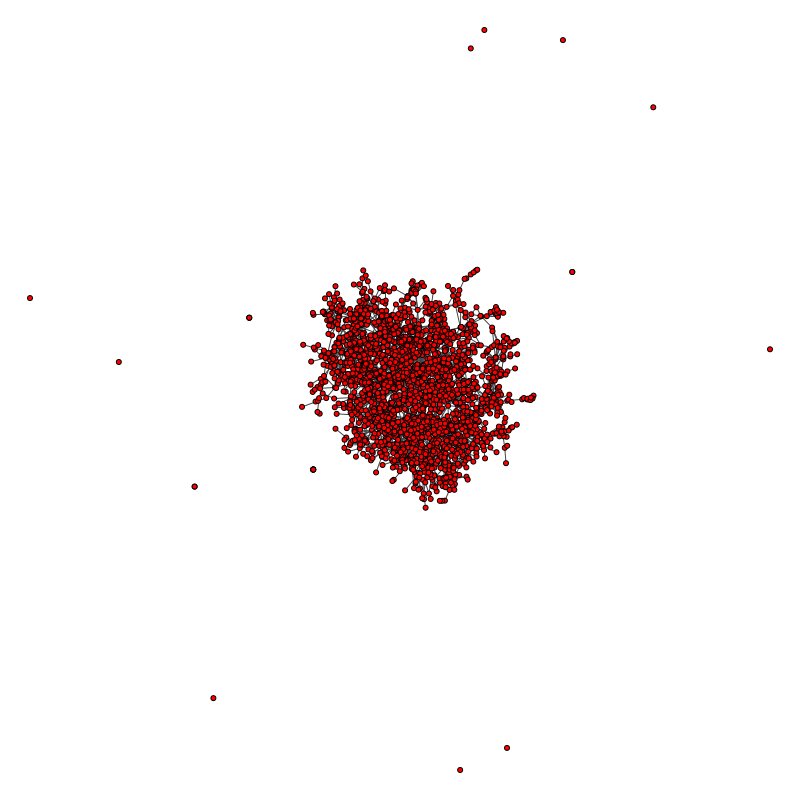

In [4]:
import matplotlib.pyplot as plt
import igraph as ig
from igraph import plot

# Define layout (auto layout works okay for quick plotting)
layout = graph.layout_fruchterman_reingold()

plot(
    graph,
    layout=layout,
    vertex_size=5,
    vertex_color='red',
    vertex_label=None,
    edge_width=1,
    bbox=(800, 800),
    margin=30
)



In [5]:
!pip install plotly

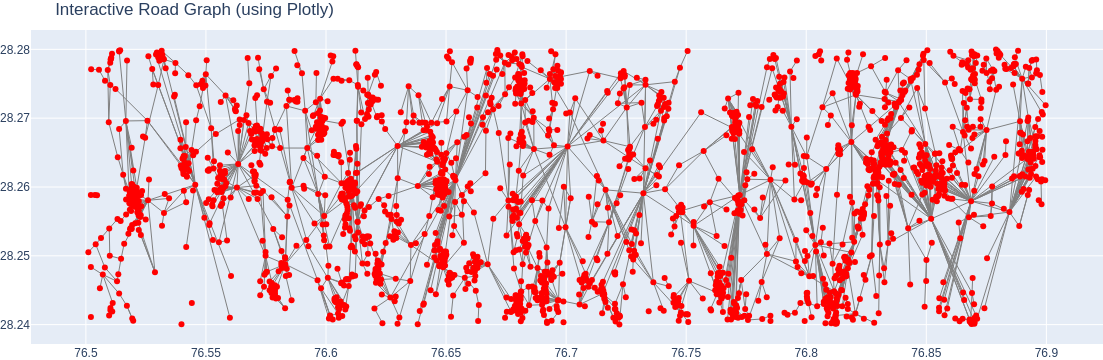

In [6]:
import plotly.graph_objects as go

coords = [g.centroid.coords[0] for g in gdf.geometry]
x = [c[0] for c in coords]
y = [c[1] for c in coords]

edge_x = []
edge_y = []
for e in graph.get_edgelist():
    i, j = e
    edge_x += [x[i], x[j], None]
    edge_y += [y[i], y[j], None]

fig = go.Figure()

# Edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'))

# Nodes
fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    marker=dict(size=6, color='red'),
    text=[f"Road {i}" for i in range(len(gdf))],
    hoverinfo='text'))

fig.update_layout(
    title="Interactive Road Graph (using Plotly)",
    showlegend=False,
    margin=dict(l=0, r=0, t=30, b=0),
    hovermode='closest'
)
fig.show()


In [7]:
n = len(graph.vs)
scale = ((n - 1) * (n - 2)) / 2

norm_betweenness = [v / scale for v in graph.betweenness(vertices=None, directed=False)]

# Print top 10 normalized values
top_nodes = sorted(enumerate(norm_betweenness), key=lambda x: x[1], reverse=True)[:10]
for node_id, centrality in top_nodes:
    print(f"Node {node_id}: Normalized Betweenness = {centrality:.6f}")


Node 2012: Normalized Betweenness = 0.501870
Node 2220: Normalized Betweenness = 0.501299
Node 139: Normalized Betweenness = 0.487146
Node 78: Normalized Betweenness = 0.464537
Node 102: Normalized Betweenness = 0.461034
Node 1131: Normalized Betweenness = 0.460136
Node 830: Normalized Betweenness = 0.427794
Node 556: Normalized Betweenness = 0.426230
Node 2069: Normalized Betweenness = 0.402785
Node 796: Normalized Betweenness = 0.401688


In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalize betweenness values
norm = mcolors.Normalize(vmin=min(betweenness), vmax=max(betweenness))
cmap = cm.get_cmap('viridis')  # or 'plasma', 'inferno', etc.
colors = [mcolors.to_hex(cmap(norm(b))) for b in betweenness]

# Plot
plot(
    graph,
    layout=layout,
    vertex_size=[3 + b / max(betweenness) * 20 for b in betweenness],
    vertex_color=colors,
    vertex_label=None,
    edge_width=1,
    bbox=(800, 800),
    margin=30
)


NameError: name 'betweenness' is not defined


Starting comprehensive network analysis...

1. DEGREE DISTRIBUTION ANALYSIS


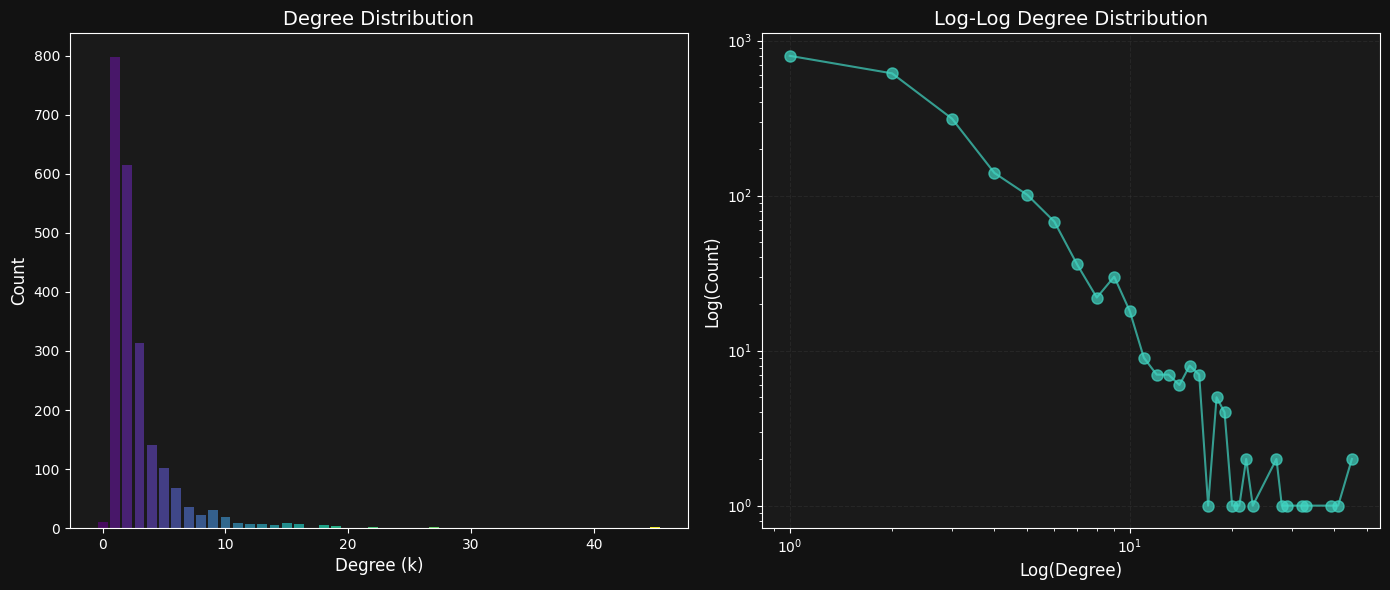

Network Degree Statistics:
Average degree: 2.95
Maximum degree: 45
Minimum degree: 0

2. CENTRALITY ANALYSIS
Calculating centrality measures...


TypeError: KDE.__init__() got an unexpected keyword argument 'color'

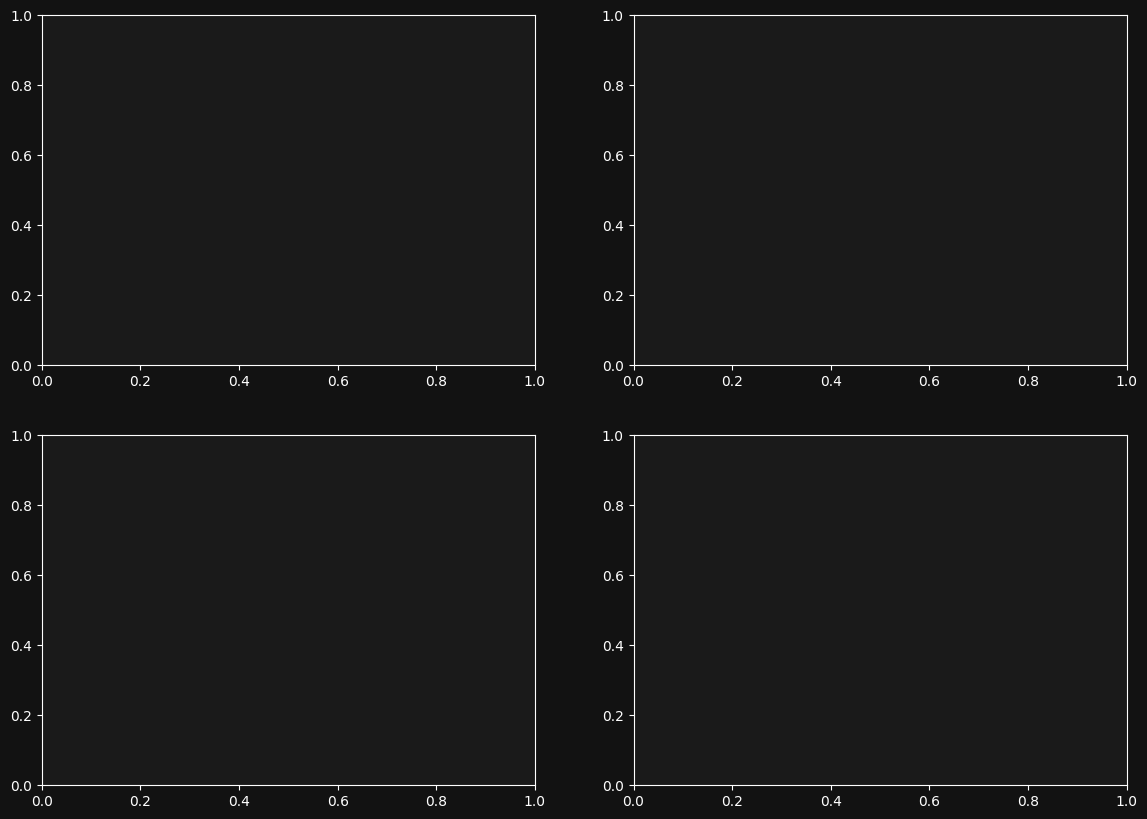

In [10]:
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from shapely.geometry import LineString
import igraph as ig
from collections import Counter
import networkx as nx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import pandas as pd

# Set dark style for plots
plt.style.use('dark_background')
custom_params = {
    "axes.facecolor": "#1a1a1a",
    "figure.facecolor": "#121212",
    "grid.color": "#444444",
    "text.color": "#ffffff",
    "axes.labelcolor": "#ffffff",
    "xtick.color": "#ffffff",
    "ytick.color": "#ffffff",
    "axes.grid": False
}
plt.rcParams.update(custom_params)

# Function to create color palettes
def generate_palette(n_colors, base_color=None, lightness_range=(0.4, 0.9)):
    if base_color:
        base = sns.color_palette(base_color, n_colors)
    else:
        base = sns.color_palette("viridis", n_colors)
    return base

# 1. Degree Distribution Analysis
def analyze_degree_distribution(graph):
    degrees = graph.degree()
    degree_counts = Counter(degrees)
    
    # Sort by degree
    x = list(sorted(degree_counts.keys()))
    y = [degree_counts[k] for k in x]
    
    # Create degree distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot degree distribution
    ax1.bar(x, y, color=generate_palette(len(x), "viridis"))
    ax1.set_title('Degree Distribution', fontsize=14)
    ax1.set_xlabel('Degree (k)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    # Plot log-log degree distribution to check for power law
    nonzero_x = [d for d in x if d > 0]
    nonzero_y = [degree_counts[d] for d in nonzero_x]
    
    if nonzero_x and nonzero_y:
        ax2.loglog(nonzero_x, nonzero_y, 'o-', color='#41d6c3', alpha=0.7, markersize=8)
        ax2.set_title('Log-Log Degree Distribution', fontsize=14)
        ax2.set_xlabel('Log(Degree)', fontsize=12)
        ax2.set_ylabel('Log(Count)', fontsize=12)
        ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('degree_distribution.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # Print degree statistics
    print(f"Network Degree Statistics:")
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Maximum degree: {max(degrees)}")
    print(f"Minimum degree: {min(degrees)}")
    
    return degrees

# 2. Centrality Analysis - FIXED FOR IGRAPH COMPATIBILITY
def calculate_centralities(graph):
    print("Calculating centrality measures...")
    
    # Calculate centrality measures
    degree_centrality = graph.degree()
    
    # Fix: Remove 'normalized' parameter from betweenness calculation
    betweenness_centrality = graph.betweenness(directed=False)
    
    # Fix: Check if closeness needs normalization parameter adjusted
    try:
        closeness_centrality = graph.closeness(normalized=True)
    except TypeError:
        # If normalized parameter causes an error, try without it
        closeness_centrality = graph.closeness()
    
    # Calculate eigenvector centrality
    try:
        eigenvector_centrality = graph.eigenvector_centrality(directed=False)
    except TypeError:
        # If directed parameter causes an error, try without it
        try:
            eigenvector_centrality = graph.eigenvector_centrality()
        except:
            # If still failing, use degree centrality as fallback
            print("Warning: Eigenvector centrality calculation failed. Using degree centrality instead.")
            eigenvector_centrality = degree_centrality
    
    # Create centrality dataframe
    centrality_measures = {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality,
        'eigenvector': eigenvector_centrality
    }
    
    # Visualize centrality distributions
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Custom color palettes for each measure
    colors = ["viridis", "plasma", "cividis", "magma"]
    
    for i, (name, values) in enumerate(centrality_measures.items()):
        ax = axes[i]
        palette = generate_palette(20, colors[i])
        sns.histplot(values, kde=True, ax=ax, color=palette[10], 
                     edgecolor=palette[15], line_kws={'linewidth': 2}, 
                     kde_kws={'color': palette[5], 'linewidth': 2})
        ax.set_title(f'{name.capitalize()} Centrality Distribution', fontsize=14)
        ax.set_xlabel(f'{name.capitalize()} Centrality', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('centrality_distributions.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # Calculate correlations between centrality measures
    centrality_df = pd.DataFrame(centrality_measures)
    correlation = centrality_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Between Centrality Measures', fontsize=16)
    plt.tight_layout()
    plt.savefig('centrality_correlation.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    return centrality_measures

# 3. Community Detection
def detect_communities(graph):
    print("Detecting communities...")
    
    # Apply multiple community detection algorithms with error handling
    communities_methods = []
    method_names = []
    modularities = []
    
    # Try Louvain method (modularity optimization)
    try:
        louvain_communities = graph.community_multilevel()
        louvain_modularity = graph.modularity(louvain_communities)
        communities_methods.append(louvain_communities)
        method_names.append("Louvain")
        modularities.append(louvain_modularity)
        print(f"Louvain method: {len(louvain_communities)} communities, modularity: {louvain_modularity:.4f}")
    except Exception as e:
        print(f"Louvain method failed: {e}")
    
    # Try Infomap method
    try:
        infomap_communities = graph.community_infomap()
        infomap_modularity = graph.modularity(infomap_communities)
        communities_methods.append(infomap_communities)
        method_names.append("Infomap")
        modularities.append(infomap_modularity)
        print(f"Infomap method: {len(infomap_communities)} communities, modularity: {infomap_modularity:.4f}")
    except Exception as e:
        print(f"Infomap method failed: {e}")
    
    # Try Label propagation
    try:
        label_prop_communities = graph.community_label_propagation()
        label_prop_modularity = graph.modularity(label_prop_communities)
        communities_methods.append(label_prop_communities)
        method_names.append("Label Propagation")
        modularities.append(label_prop_modularity)
        print(f"Label propagation: {len(label_prop_communities)} communities, modularity: {label_prop_modularity:.4f}")
    except Exception as e:
        print(f"Label propagation method failed: {e}")
    
    # If all methods failed, use a fallback method
    if not communities_methods:
        try:
            # Fallback to edge betweenness community detection
            edge_betw_communities = graph.community_edge_betweenness().as_clustering()
            edge_betw_modularity = graph.modularity(edge_betw_communities)
            communities_methods.append(edge_betw_communities)
            method_names.append("Edge Betweenness")
            modularities.append(edge_betw_modularity)
            print(f"Edge Betweenness: {len(edge_betw_communities)} communities, modularity: {edge_betw_modularity:.4f}")
        except Exception as e:
            print(f"All community detection methods failed. Using vertex clustering as last resort.")
            # Last resort: each connected component is a community
            fallback_communities = graph.components()
            fallback_modularity = graph.modularity(fallback_communities)
            communities_methods.append(fallback_communities)
            method_names.append("Connected Components")
            modularities.append(fallback_modularity)
    
    # Select the method with highest modularity
    if modularities:
        best_idx = modularities.index(max(modularities))
        best_method = communities_methods[best_idx]
        best_method_name = method_names[best_idx]
        
        print(f"Using {best_method_name} method with highest modularity ({modularities[best_idx]:.4f})")
    else:
        print("No community detection method worked. Cannot perform community analysis.")
        return None, "None"
    
    # Plot community size distribution
    community_sizes = [len(comm) for comm in best_method]
    
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(community_sizes, kde=False, bins=30, color="#5cbae6", edgecolor="#2980b9")
    plt.title(f'Community Size Distribution ({best_method_name} method)', fontsize=14)
    plt.xlabel('Community Size', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Add summary statistics
    textstr = '\n'.join((
        f'Communities: {len(best_method)}',
        f'Modularity: {modularities[best_idx]:.4f}',
        f'Avg Size: {np.mean(community_sizes):.1f}',
        f'Max Size: {max(community_sizes)}',
        f'Min Size: {min(community_sizes)}'
    ))
    
    props = dict(boxstyle='round', facecolor='#333333', alpha=0.8)
    plt.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center', bbox=props)
    
    plt.tight_layout()
    plt.savefig('community_size_distribution.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    return best_method, best_method_name

# 4. Network Visualization with spatial data
def visualize_network(graph, gdf, centrality_measures, communities, community_method_name):
    print("Creating network visualizations...")
    
    # Skip if communities detection failed
    if communities is None:
        print("Skipping community visualization as community detection failed.")
        community_vis = False
    else:
        community_vis = True
        # 4.1 Create a complex visualization combining communities with centrality
        membership = []
        for i in range(graph.vcount()):
            for j, comm in enumerate(communities):
                if i in comm:
                    membership.append(j)
                    break
        
        # Create a color map for communities - use a colorful palette
        unique_communities = len(set(membership))
        community_colors = generate_palette(unique_communities, "hsv")
        node_colors = [community_colors[m % len(community_colors)] for m in membership]
        
        # Plot the spatial network with communities
        plt.figure(figsize=(16, 12))
        
        # Plot the lines with community colors
        for i, feature in enumerate(gdf.geometry):
            if i < len(membership):  # Safety check
                comm_idx = membership[i]
                plt.plot(*feature.xy, color=community_colors[comm_idx % len(community_colors)], 
                        linewidth=1.5, alpha=0.7)
        
        # Add legend for communities (limit to top 10 by size if there are many)
        comm_sizes = [len(comm) for comm in communities]
        top_communities = sorted(range(len(comm_sizes)), key=lambda i: comm_sizes[i], reverse=True)[:min(10, len(comm_sizes))]
        
        legend_patches = []
        for i, comm_idx in enumerate(top_communities):
            patch = mpatches.Patch(color=community_colors[comm_idx % len(community_colors)], 
                                label=f'Community {comm_idx+1} (size: {comm_sizes[comm_idx]})')
            legend_patches.append(patch)
        
        plt.legend(handles=legend_patches, loc='upper right', title=f"{community_method_name} Communities")
        plt.title(f'Geospatial Network Visualization with Communities', fontsize=16)
        plt.grid(False)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('geospatial_network_communities.png', dpi=300, bbox_inches='tight', facecolor="#121212")
        plt.show()
    
    # 4.2 Create a betweenness centrality visualization
    plt.figure(figsize=(16, 12))
    
    # Normalize betweenness for coloring
    betweenness = centrality_measures['betweenness']
    max_betweenness = max(betweenness) if betweenness else 1
    
    # Create a colormap
    cmap = plt.cm.viridis
    
    # Plot lines with color based on betweenness
    for i, feature in enumerate(gdf.geometry):
        if i < len(betweenness):  # Safety check
            if max_betweenness > 0:  # Avoid division by zero
                norm_value = betweenness[i] / max_betweenness
            else:
                norm_value = 0
                
            line_color = cmap(norm_value)
            line_width = 1 + 3 * norm_value  # Scale line width based on betweenness
            
            plt.plot(*feature.xy, color=line_color, linewidth=line_width, alpha=0.7)
    
    # Add a colorbar
    norm = Normalize(vmin=0, vmax=max_betweenness)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('Betweenness Centrality', size=12)
    
    plt.title('Geospatial Network - Betweenness Centrality', fontsize=16)
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('geospatial_betweenness.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # 4.3 Create a degree centrality visualization
    plt.figure(figsize=(16, 12))
    
    # Normalize degree for coloring
    degrees = centrality_measures['degree']
    max_degree = max(degrees) if degrees else 1
    
    # Create a colormap - use a different one for variety
    cmap = plt.cm.plasma
    
    # Plot lines with color based on degree
    for i, feature in enumerate(gdf.geometry):
        if i < len(degrees):  # Safety check
            norm_value = degrees[i] / max_degree if max_degree > 0 else 0
            line_color = cmap(norm_value)
            line_width = 1 + 3 * norm_value  # Scale line width based on degree
            
            plt.plot(*feature.xy, color=line_color, linewidth=line_width, alpha=0.7)
    
    # Add a colorbar
    norm = Normalize(vmin=0, vmax=max_degree)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('Degree Centrality', size=12)
    
    plt.title('Geospatial Network - Degree Centrality', fontsize=16)
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('geospatial_degree.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()

# Let's add another useful analysis - network metrics summary
def network_metrics_summary(graph):
    # Calculate overall network metrics with error handling
    try:
        avg_path_length = graph.average_path_length(directed=False, unconn=True)
    except:
        try:
            # Try without unconn parameter
            avg_path_length = graph.average_path_length(directed=False)
        except:
            avg_path_length = "N/A"
    
    try:
        diameter = graph.diameter(directed=False, unconn=True)
    except:
        try:
            # Try without unconn parameter
            diameter = graph.diameter(directed=False)
        except:
            diameter = "N/A"
    
    density = graph.density()
    
    try:
        clustering_coef = graph.transitivity_avglocal_undirected()
    except:
        try:
            # Try global transitivity as fallback
            clustering_coef = graph.transitivity_undirected()
        except:
            clustering_coef = "N/A"
    
    # Identify articulation points (cut vertices)
    try:
        cut_vertices = graph.cut_vertices()
    except:
        cut_vertices = []
    
    # Identify connected components
    components = graph.components()
    component_sizes = [len(comp) for comp in components]
    
    # Create a summary plot
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    
    # Create a text summary with dark background styling
    textstr = '\n'.join((
        f'NETWORK SUMMARY METRICS',
        f'------------------------',
        f'Nodes: {graph.vcount()}',
        f'Edges: {graph.ecount()}',
        f'Density: {density:.4f}',
        f'Average Path Length: {avg_path_length if isinstance(avg_path_length, str) else avg_path_length:.4f}',
        f'Diameter: {diameter}',
        f'Clustering Coefficient: {clustering_coef if isinstance(clustering_coef, str) else clustering_coef:.4f}',
        f'Components: {len(components)}',
        f'Largest Component Size: {max(component_sizes) if component_sizes else 0}',
        f'Cut Vertices: {len(cut_vertices)}',
    ))
    
    props = dict(boxstyle='round', facecolor='#333333', alpha=0.9)
    plt.text(0.5, 0.5, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='center', horizontalalignment='center', bbox=props,
            family='monospace')
    
    plt.tight_layout()
    plt.savefig('network_metrics_summary.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # Return key metrics
    return {
        'avg_path_length': avg_path_length,
        'diameter': diameter, 
        'density': density,
        'clustering': clustering_coef,
        'components': len(components),
        'cut_vertices': len(cut_vertices)
    }

# Now run all analyses in sequence
# Make sure this code runs after your graph and GeoDataFrame are created
if 'graph' in locals() and 'gdf' in locals():
    print("\n" + "="*50)
    print("Starting comprehensive network analysis...")
    print("="*50)
    
    # Step 1: Analyze degree distribution
    print("\n1. DEGREE DISTRIBUTION ANALYSIS")
    degrees = analyze_degree_distribution(graph)
    
    # Step 2: Calculate centrality measures
    print("\n2. CENTRALITY ANALYSIS")
    centrality_measures = calculate_centralities(graph)
    
    # Step 3: Detect communities
    print("\n3. COMMUNITY DETECTION")
    communities, community_method_name = detect_communities(graph)
    
    # Step 4: Network metrics summary
    print("\n4. NETWORK METRICS SUMMARY")
    metrics = network_metrics_summary(graph)
    
    # Step 5: Visualize the network
    print("\n5. NETWORK VISUALIZATION")
    visualize_network(graph, gdf, centrality_measures, communities, community_method_name)
    
    print("\n" + "="*50)
    print("Network analysis complete. All visualizations have been saved.")
    print("="*50)
else:
    print("Error: Graph or GeoDataFrame not found. Make sure to run the initial data loading code first.")

In [19]:
import json
import geopandas as gpd
from shapely.geometry import LineString
import igraph as ig
import multiprocessing as mp

# Step 1: Load GeoJSON
with open("filtered_output_2_small.geojson", "r") as f:
    data = json.load(f)

# Step 2: Filter valid LineStrings
valid_features = []
for feature in data['features']:
    coords = feature['geometry']['coordinates']
    if feature['geometry']['type'] == "LineString" and len(coords) >= 2:
        valid_features.append(feature)

# Step 3: Create GeoDataFrame
geometries = [LineString(f["geometry"]["coordinates"]) for f in valid_features]
gdf = gpd.GeoDataFrame(valid_features, geometry=geometries)
gdf.reset_index(drop=True, inplace=True)
geom_list = gdf.geometry.values

# Step 4: Parallel pairwise intersection checking
def check_chunk(start, end):
    local_edges = []
    for i in range(start, end):
        g1 = geom_list[i]
        for j in range(i + 1, len(geom_list)):
            g2 = geom_list[j]
            try:
                if g1.intersects(g2):
                    local_edges.append((i, j))
            except:
                continue
    return local_edges

def parallel_intersection(n_workers=mp.cpu_count()):
    chunk_size = len(geom_list) // n_workers
    ranges = [(i * chunk_size, (i + 1) * chunk_size if i != n_workers - 1 else len(geom_list)) for i in range(n_workers)]

    with mp.Pool(processes=n_workers) as pool:
        results = pool.starmap(check_chunk, ranges)

    edges = [e for sub in results for e in sub]
    return edges

if __name__ == "__main__":
    edges = parallel_intersection()

    # Step 5: Build graph
    graph = ig.Graph()
    graph.add_vertices(len(gdf))
    graph.add_edges(edges)
    print("Before filtering:", g.summary())

    # Step 6: Remove nodes with degree 1 or 2
    degrees = graph.degree()
    to_remove = [i for i, d in enumerate(degrees) if d == 1 or d == 0]
    graph.delete_vertices(to_remove)

    print("After filtering:", graph.summary())


Before filtering: IGRAPH U--- 809 1411 -- 
After filtering: IGRAPH U--- 1413 2478 -- 



Starting comprehensive network analysis...

1. DEGREE DISTRIBUTION ANALYSIS


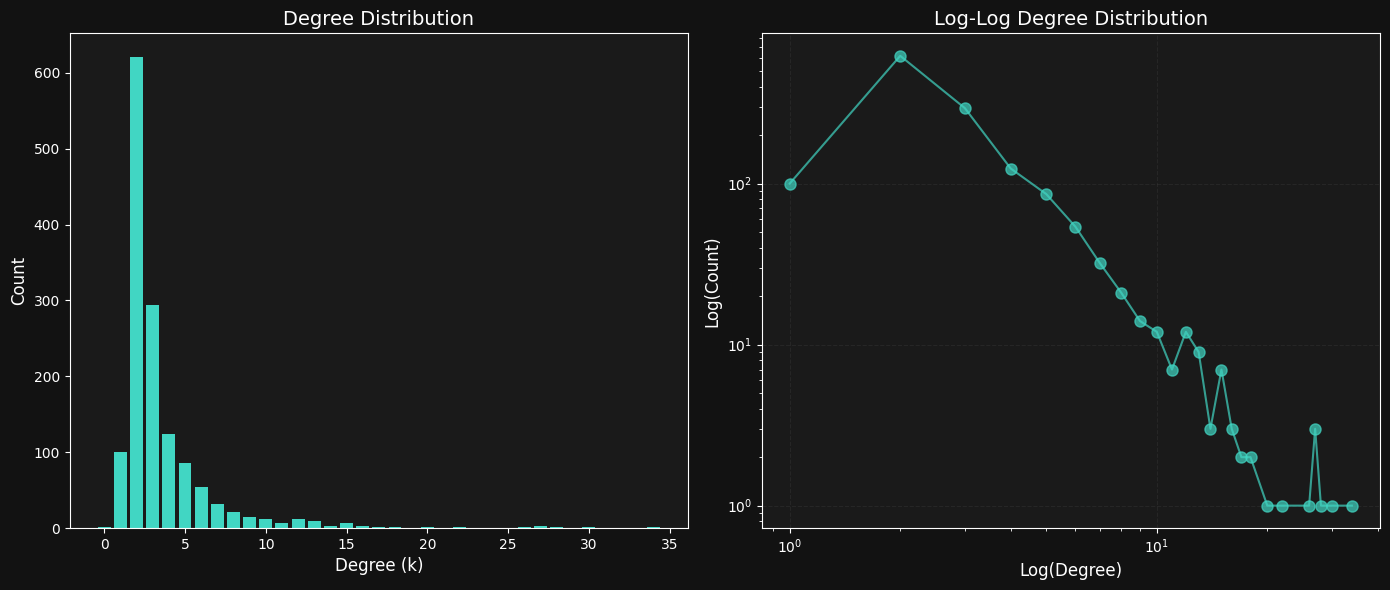

Network Degree Statistics:
Average degree: 3.51
Maximum degree: 34
Minimum degree: 0

2. CENTRALITY ANALYSIS
Calculating centrality measures...


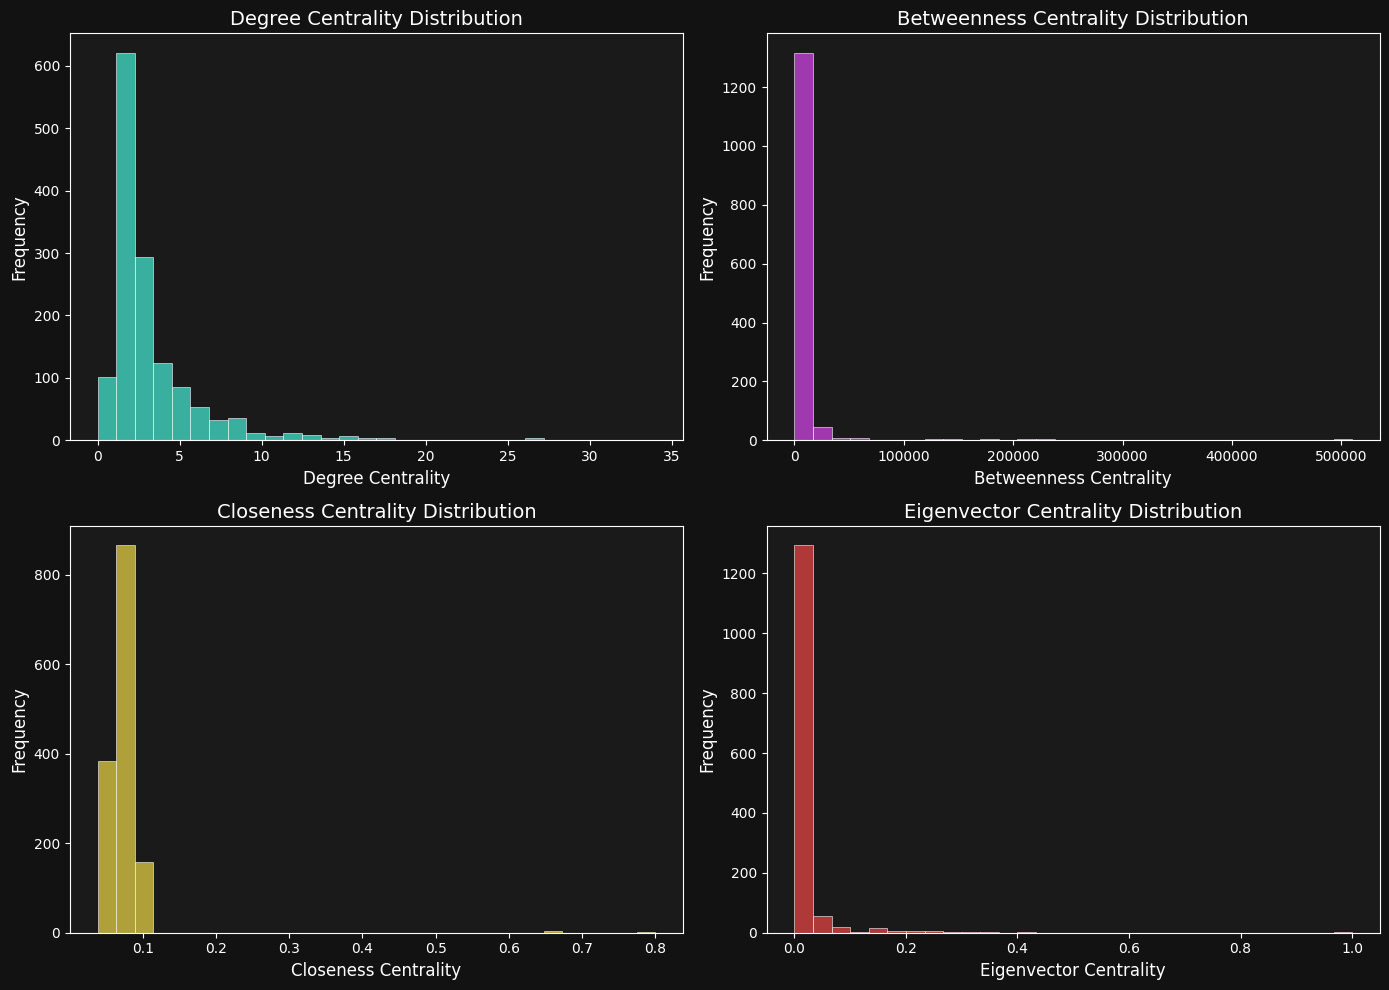

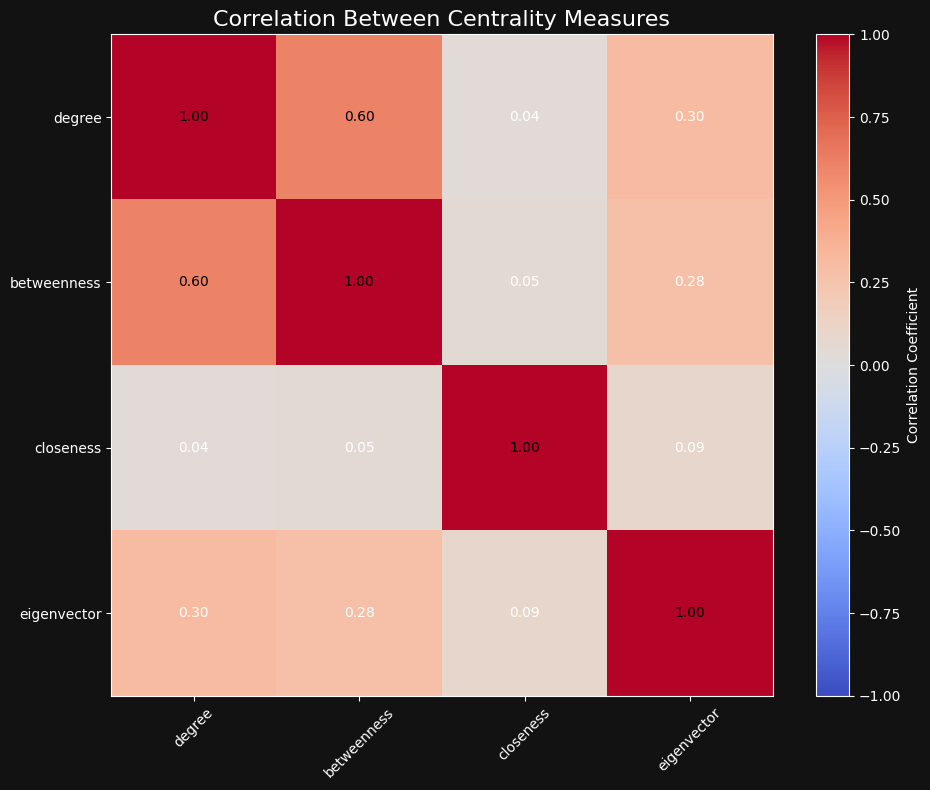


3. COMMUNITY DETECTION
Detecting communities...
Louvain method: 25 communities, modularity: 0.8950
Label propagation: 95 communities, modularity: 0.8197
Using Louvain method with highest modularity (0.8950)


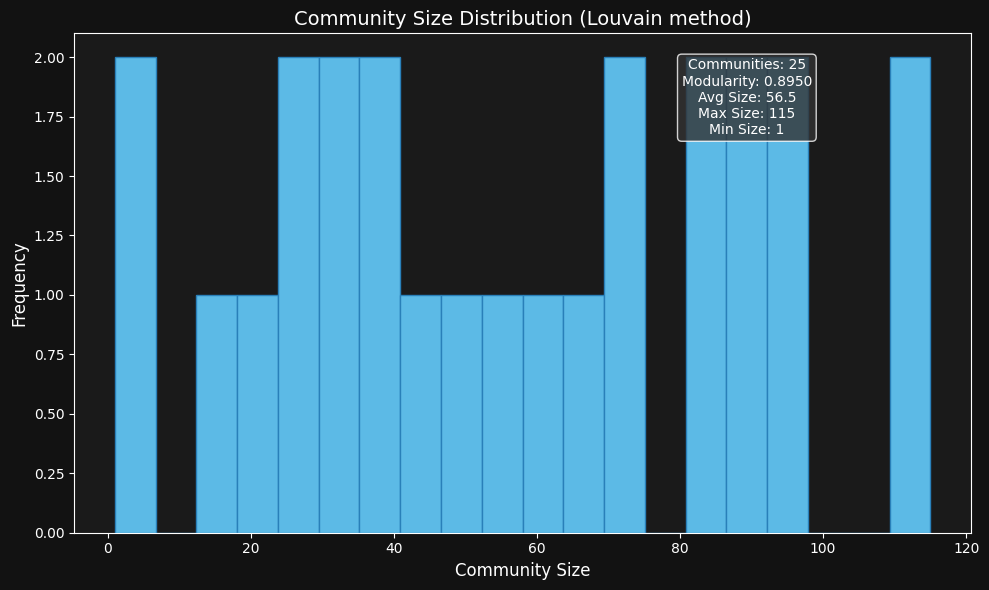


4. NETWORK METRICS SUMMARY


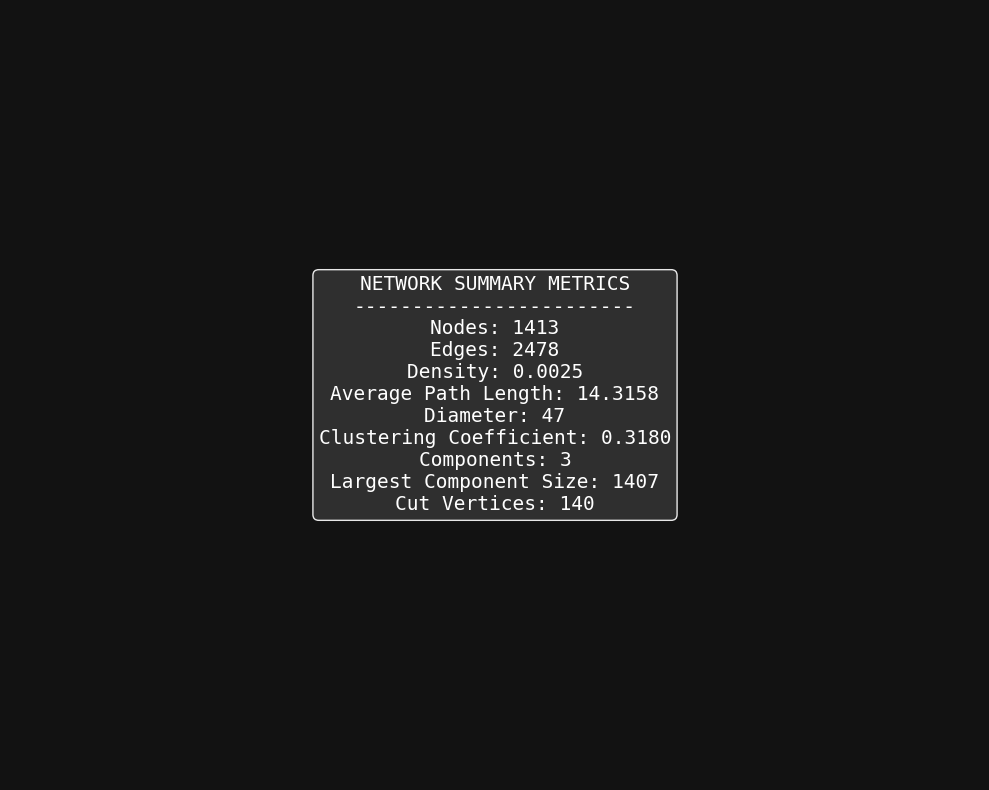


5. NETWORK VISUALIZATION
Creating network visualizations...


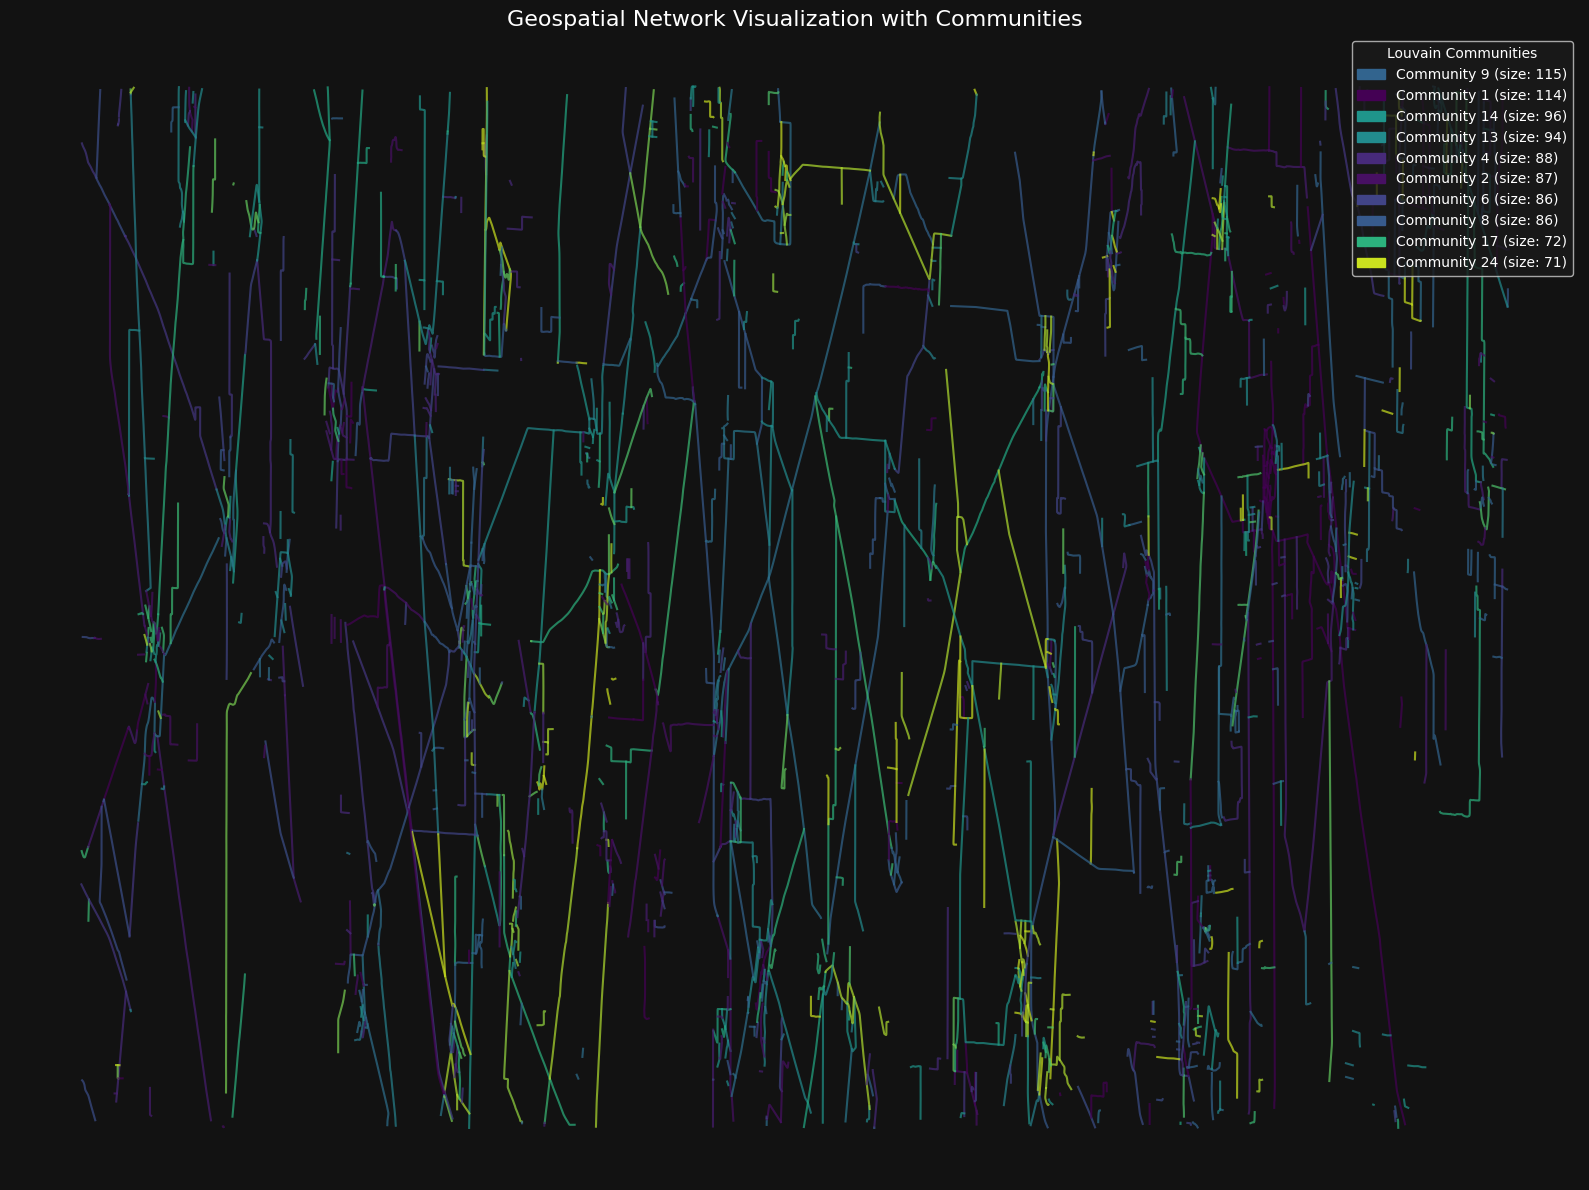

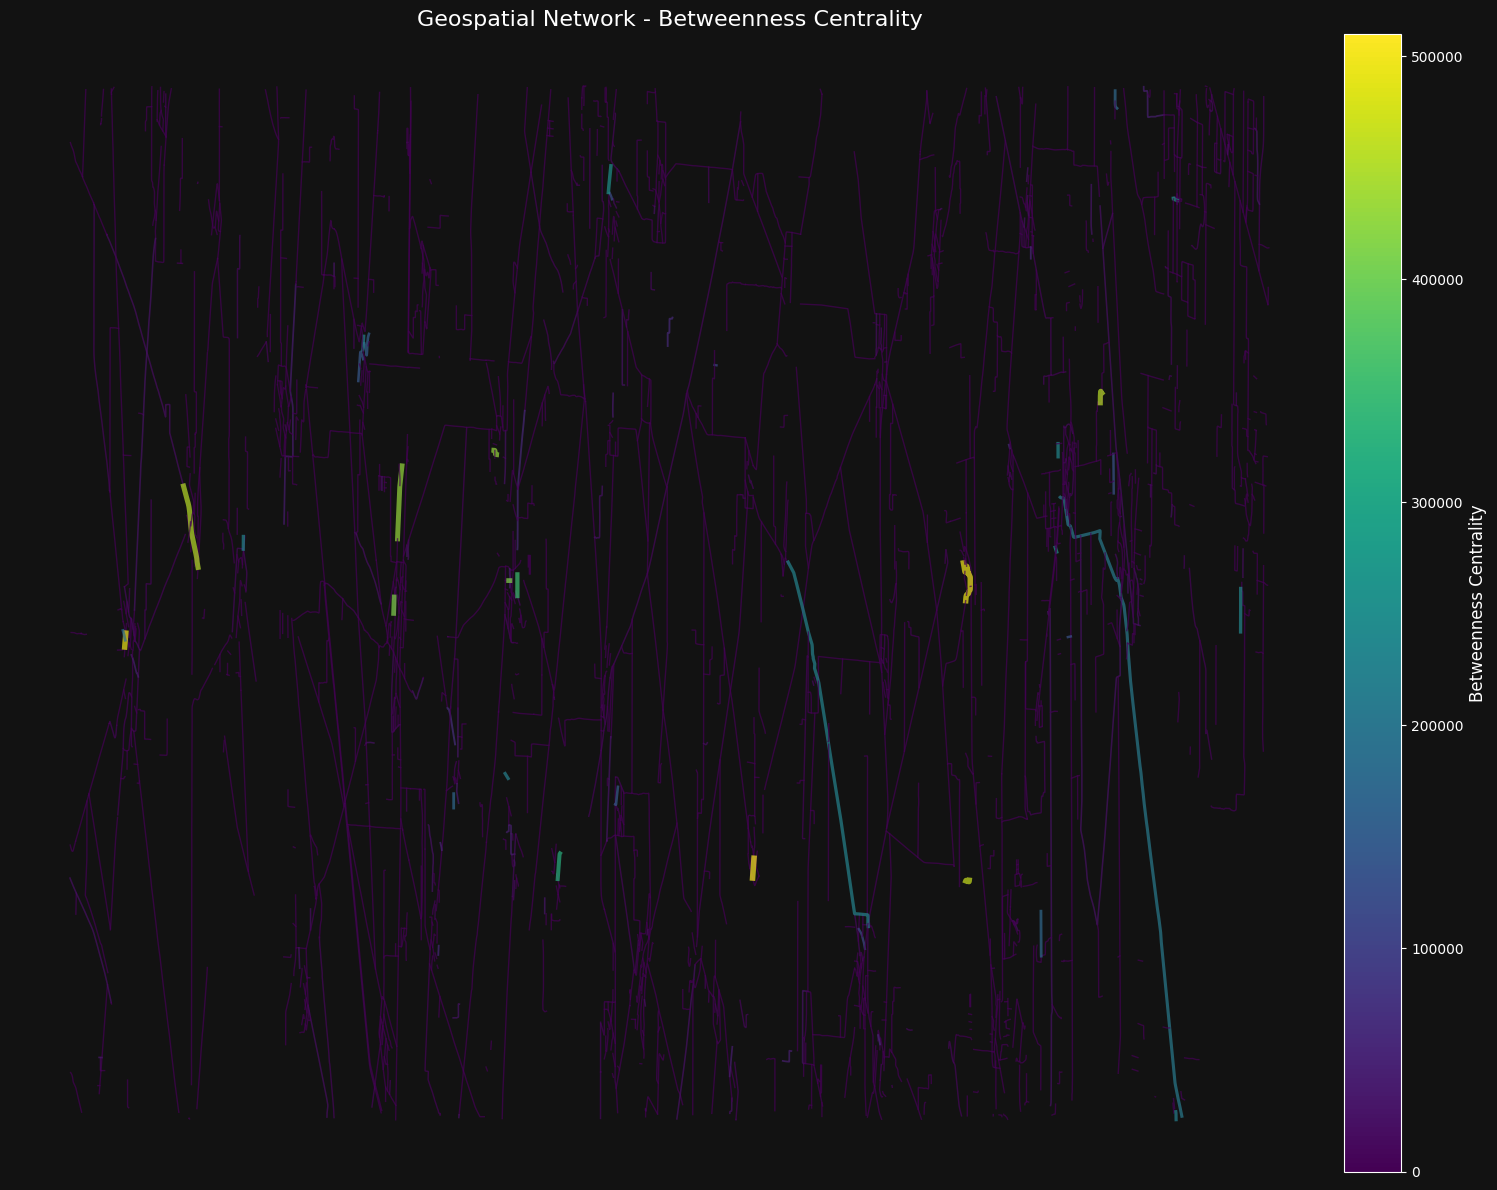

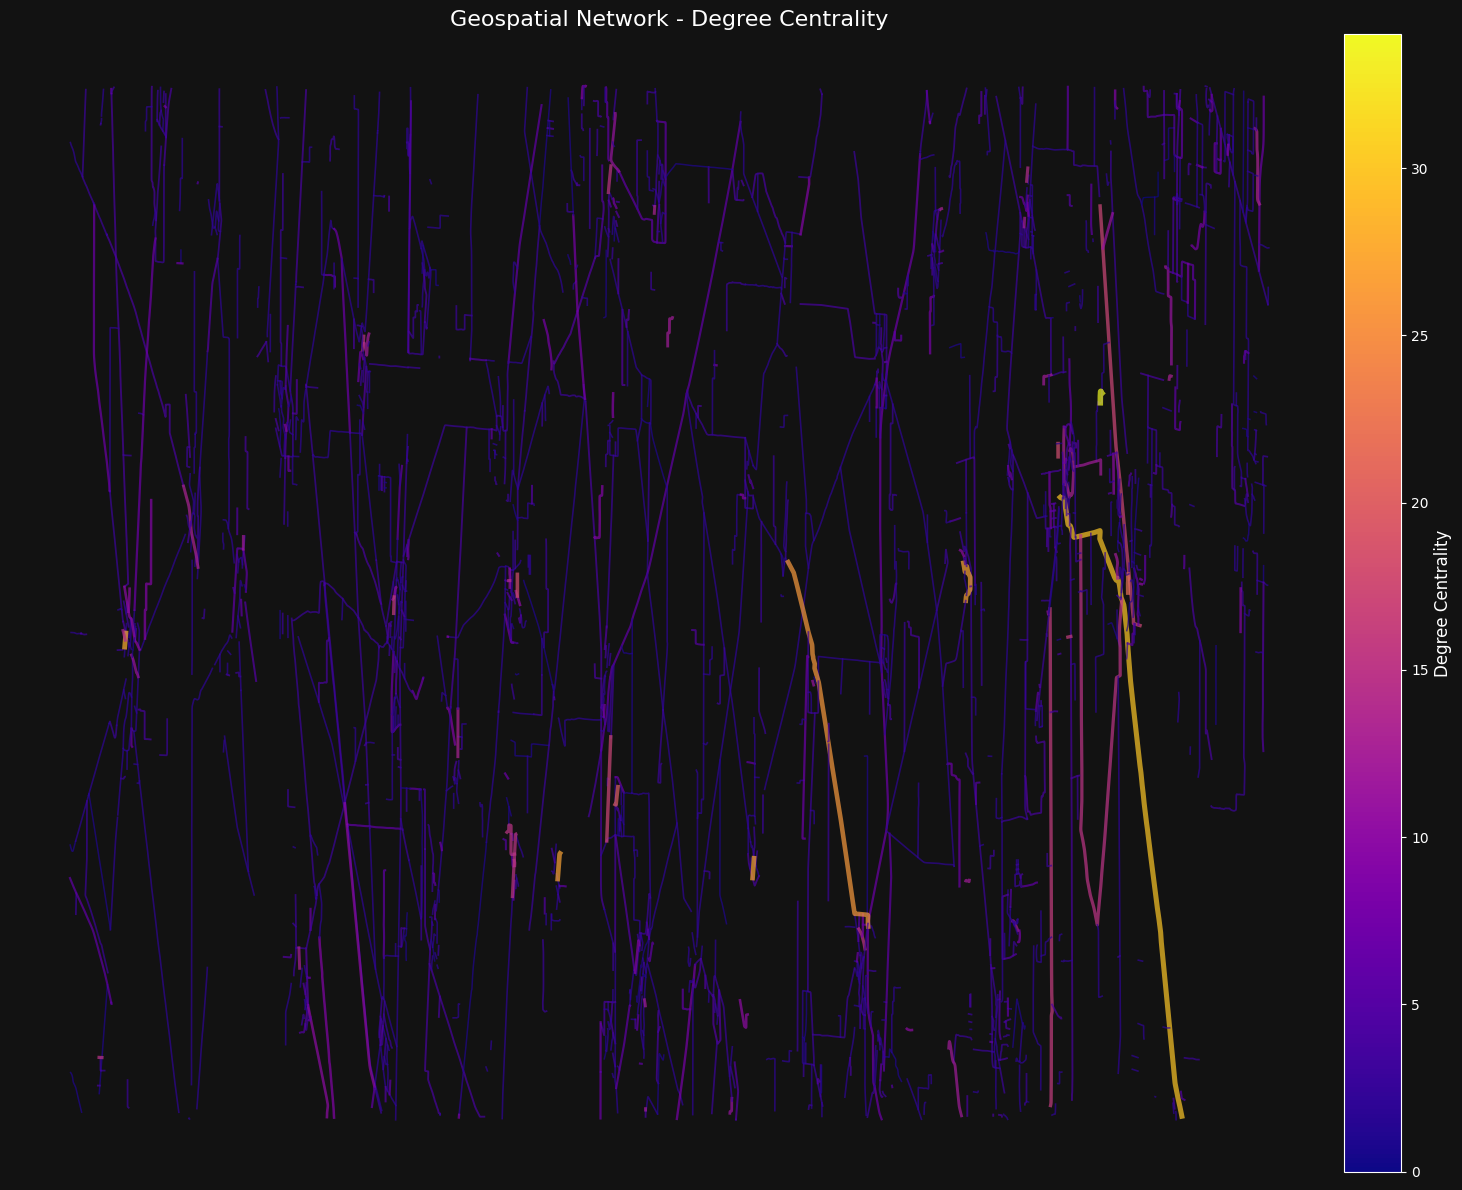


Network analysis complete. All visualizations have been saved.


In [20]:
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import LineString
import igraph as ig
from collections import Counter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import pandas as pd

# Set dark style for plots
plt.style.use('dark_background')
custom_params = {
    "axes.facecolor": "#1a1a1a",
    "figure.facecolor": "#121212",
    "grid.color": "#444444",
    "text.color": "#ffffff",
    "axes.labelcolor": "#ffffff",
    "xtick.color": "#ffffff",
    "ytick.color": "#ffffff",
    "axes.grid": False
}
plt.rcParams.update(custom_params)

# 1. Degree Distribution Analysis
def analyze_degree_distribution(graph):
    degrees = graph.degree()
    degree_counts = Counter(degrees)
    
    # Sort by degree
    x = list(sorted(degree_counts.keys()))
    y = [degree_counts[k] for k in x]
    
    # Create degree distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot degree distribution - simplified
    ax1.bar(x, y, color='#41d6c3')
    ax1.set_title('Degree Distribution', fontsize=14)
    ax1.set_xlabel('Degree (k)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    # Plot log-log degree distribution to check for power law
    nonzero_x = [d for d in x if d > 0]
    nonzero_y = [degree_counts[d] for d in nonzero_x]
    
    if nonzero_x and nonzero_y:
        ax2.loglog(nonzero_x, nonzero_y, 'o-', color='#41d6c3', alpha=0.7, markersize=8)
        ax2.set_title('Log-Log Degree Distribution', fontsize=14)
        ax2.set_xlabel('Log(Degree)', fontsize=12)
        ax2.set_ylabel('Log(Count)', fontsize=12)
        ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('degree_distribution.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # Print degree statistics
    print(f"Network Degree Statistics:")
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Maximum degree: {max(degrees)}")
    print(f"Minimum degree: {min(degrees)}")
    
    return degrees

# 2. Centrality Analysis - SIMPLIFIED FOR COMPATIBILITY
def calculate_centralities(graph):
    print("Calculating centrality measures...")
    
    # Calculate centrality measures
    degree_centrality = graph.degree()
    
    # Fix: Remove parameters that could cause errors
    betweenness_centrality = graph.betweenness(directed=False)
    
    # Try closeness centrality with error handling
    try:
        closeness_centrality = graph.closeness(normalized=True)
    except TypeError:
        # If normalized parameter causes an error, try without it
        closeness_centrality = graph.closeness()
    
    # Calculate eigenvector centrality with error handling
    try:
        eigenvector_centrality = graph.eigenvector_centrality(directed=False)
    except Exception as e:
        print(f"Eigenvector centrality calculation failed: {e}")
        print("Using degree centrality as a fallback")
        eigenvector_centrality = degree_centrality
    
    # Create centrality dataframe
    centrality_measures = {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality,
        'eigenvector': eigenvector_centrality
    }
    
    # SIMPLIFIED: Use direct matplotlib plotting instead of seaborn's kde
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Custom colors for each measure - simplified
    colors = ['#41d6c3', '#c341d6', '#d6c341', '#d64141']
    
    for i, (name, values) in enumerate(centrality_measures.items()):
        ax = axes[i]
        # Simple histogram instead of complex kde
        ax.hist(values, bins=30, color=colors[i], alpha=0.8, edgecolor='white', linewidth=0.5)
        ax.set_title(f'{name.capitalize()} Centrality Distribution', fontsize=14)
        ax.set_xlabel(f'{name.capitalize()} Centrality', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('centrality_distributions.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # Calculate correlations between centrality measures
    centrality_df = pd.DataFrame(centrality_measures)
    correlation = centrality_df.corr()
    
    # Simple heatmap without seaborn
    plt.figure(figsize=(10, 8))
    im = plt.imshow(correlation, cmap='coolwarm', vmin=-1, vmax=1)
    
    # Add correlation values
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            text = plt.text(j, i, f'{correlation.iloc[i, j]:.2f}',
                           ha="center", va="center", color="white" if abs(correlation.iloc[i, j]) < 0.5 else "black")
    
    plt.colorbar(im, label='Correlation Coefficient')
    plt.xticks(range(len(correlation)), correlation.columns, rotation=45)
    plt.yticks(range(len(correlation)), correlation.index)
    plt.title('Correlation Between Centrality Measures', fontsize=16)
    plt.tight_layout()
    plt.savefig('centrality_correlation.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    return centrality_measures

# 3. Community Detection - SIMPLIFIED
def detect_communities(graph):
    print("Detecting communities...")
    
    # Apply multiple community detection algorithms with error handling
    communities_methods = []
    method_names = []
    modularities = []
    
    # Try Louvain method (modularity optimization)
    try:
        louvain_communities = graph.community_multilevel()
        louvain_modularity = graph.modularity(louvain_communities)
        communities_methods.append(louvain_communities)
        method_names.append("Louvain")
        modularities.append(louvain_modularity)
        print(f"Louvain method: {len(louvain_communities)} communities, modularity: {louvain_modularity:.4f}")
    except Exception as e:
        print(f"Louvain method failed: {e}")
    
    # Try Label propagation
    try:
        label_prop_communities = graph.community_label_propagation()
        label_prop_modularity = graph.modularity(label_prop_communities)
        communities_methods.append(label_prop_communities)
        method_names.append("Label Propagation")
        modularities.append(label_prop_modularity)
        print(f"Label propagation: {len(label_prop_communities)} communities, modularity: {label_prop_modularity:.4f}")
    except Exception as e:
        print(f"Label propagation method failed: {e}")
    
    # If all methods failed, use a fallback method
    if not communities_methods:
        try:
            # Fallback to connected components
            fallback_communities = graph.components()
            fallback_modularity = graph.modularity(fallback_communities)
            communities_methods.append(fallback_communities)
            method_names.append("Connected Components")
            modularities.append(fallback_modularity)
            print(f"Connected Components: {len(fallback_communities)} communities, modularity: {fallback_modularity:.4f}")
        except Exception as e:
            print(f"All community detection methods failed: {e}")
            return None, "None"
    
    # Select the method with highest modularity
    if modularities:
        best_idx = modularities.index(max(modularities))
        best_method = communities_methods[best_idx]
        best_method_name = method_names[best_idx]
        
        print(f"Using {best_method_name} method with highest modularity ({modularities[best_idx]:.4f})")
    else:
        print("No community detection method worked. Cannot perform community analysis.")
        return None, "None"
    
    # Plot community size distribution - simplified
    community_sizes = [len(comm) for comm in best_method]
    
    plt.figure(figsize=(10, 6))
    plt.hist(community_sizes, bins=20, color="#5cbae6", edgecolor="#2980b9")
    plt.title(f'Community Size Distribution ({best_method_name} method)', fontsize=14)
    plt.xlabel('Community Size', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Add summary statistics
    textstr = '\n'.join((
        f'Communities: {len(best_method)}',
        f'Modularity: {modularities[best_idx]:.4f}',
        f'Avg Size: {np.mean(community_sizes):.1f}',
        f'Max Size: {max(community_sizes)}',
        f'Min Size: {min(community_sizes)}'
    ))
    
    props = dict(boxstyle='round', facecolor='#333333', alpha=0.8)
    plt.text(0.75, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center', bbox=props)
    
    plt.tight_layout()
    plt.savefig('community_size_distribution.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    return best_method, best_method_name

# 4. Network Visualization with spatial data - SIMPLIFIED
def visualize_network(graph, gdf, centrality_measures, communities, community_method_name):
    print("Creating network visualizations...")
    
    # Skip if communities detection failed
    if communities is None:
        print("Skipping community visualization as community detection failed.")
        community_vis = False
    else:
        community_vis = True
        # 4.1 Create a complex visualization combining communities with centrality
        membership = []
        for i in range(graph.vcount()):
            for j, comm in enumerate(communities):
                if i in comm:
                    membership.append(j)
                    break
        
        # Create a color map for communities - simplified to use standard colormap
        unique_communities = len(set(membership))
        colormap = plt.cm.tab20 if unique_communities <= 20 else plt.cm.viridis
        
        # Plot the spatial network with communities
        plt.figure(figsize=(16, 12))
        
        # Plot the lines with community colors
        for i, feature in enumerate(gdf.geometry):
            if i < len(membership):  # Safety check
                comm_idx = membership[i]
                color_val = comm_idx % unique_communities / unique_communities
                plt.plot(*feature.xy, color=colormap(color_val), linewidth=1.5, alpha=0.7)
        
        # Add legend for communities (limit to top 10 by size if there are many)
        comm_sizes = [len(comm) for comm in communities]
        top_communities = sorted(range(len(comm_sizes)), key=lambda i: comm_sizes[i], reverse=True)[:min(10, len(comm_sizes))]
        
        legend_patches = []
        for i, comm_idx in enumerate(top_communities):
            color_val = comm_idx % unique_communities / unique_communities
            patch = mpatches.Patch(color=colormap(color_val), 
                                label=f'Community {comm_idx+1} (size: {comm_sizes[comm_idx]})')
            legend_patches.append(patch)
        
        plt.legend(handles=legend_patches, loc='upper right', title=f"{community_method_name} Communities")
        plt.title(f'Geospatial Network Visualization with Communities', fontsize=16)
        plt.grid(False)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('geospatial_network_communities.png', dpi=300, bbox_inches='tight', facecolor="#121212")
        plt.show()
    
    # 4.2 Create a betweenness centrality visualization
    plt.figure(figsize=(16, 12))
    
    # Normalize betweenness for coloring
    betweenness = centrality_measures['betweenness']
    max_betweenness = max(betweenness) if betweenness else 1
    
    # Create a colormap
    cmap = plt.cm.viridis
    
    # Plot lines with color based on betweenness
    for i, feature in enumerate(gdf.geometry):
        if i < len(betweenness):  # Safety check
            if max_betweenness > 0:  # Avoid division by zero
                norm_value = betweenness[i] / max_betweenness
            else:
                norm_value = 0
                
            line_color = cmap(norm_value)
            line_width = 1 + 3 * norm_value  # Scale line width based on betweenness
            
            plt.plot(*feature.xy, color=line_color, linewidth=line_width, alpha=0.7)
    
    # Add a colorbar
    norm = Normalize(vmin=0, vmax=max_betweenness)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('Betweenness Centrality', size=12)
    
    plt.title('Geospatial Network - Betweenness Centrality', fontsize=16)
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('geospatial_betweenness.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # 4.3 Create a degree centrality visualization
    plt.figure(figsize=(16, 12))
    
    # Normalize degree for coloring
    degrees = centrality_measures['degree']
    max_degree = max(degrees) if degrees else 1
    
    # Create a colormap - use a different one for variety
    cmap = plt.cm.plasma
    
    # Plot lines with color based on degree
    for i, feature in enumerate(gdf.geometry):
        if i < len(degrees):  # Safety check
            norm_value = degrees[i] / max_degree if max_degree > 0 else 0
            line_color = cmap(norm_value)
            line_width = 1 + 3 * norm_value  # Scale line width based on degree
            
            plt.plot(*feature.xy, color=line_color, linewidth=line_width, alpha=0.7)
    
    # Add a colorbar
    norm = Normalize(vmin=0, vmax=max_degree)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('Degree Centrality', size=12)
    
    plt.title('Geospatial Network - Degree Centrality', fontsize=16)
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('geospatial_degree.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()

# Network metrics summary
def network_metrics_summary(graph):
    # Calculate overall network metrics with error handling
    try:
        avg_path_length = graph.average_path_length(directed=False, unconn=True)
    except:
        try:
            # Try without unconn parameter
            avg_path_length = graph.average_path_length(directed=False)
        except:
            avg_path_length = "N/A"
    
    try:
        diameter = graph.diameter(directed=False, unconn=True)
    except:
        try:
            # Try without unconn parameter
            diameter = graph.diameter(directed=False)
        except:
            diameter = "N/A"
    
    density = graph.density()
    
    try:
        clustering_coef = graph.transitivity_avglocal_undirected()
    except:
        try:
            # Try global transitivity as fallback
            clustering_coef = graph.transitivity_undirected()
        except:
            clustering_coef = "N/A"
    
    # Identify articulation points (cut vertices)
    try:
        cut_vertices = graph.cut_vertices()
    except:
        cut_vertices = []
    
    # Identify connected components
    components = graph.components()
    component_sizes = [len(comp) for comp in components]
    
    # Create a summary plot - simplified to avoid rendering issues
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    
    # Create a text summary with dark background styling
    textstr = '\n'.join((
        f'NETWORK SUMMARY METRICS',
        f'------------------------',
        f'Nodes: {graph.vcount()}',
        f'Edges: {graph.ecount()}',
        f'Density: {density:.4f}',
        f'Average Path Length: {avg_path_length if isinstance(avg_path_length, str) else avg_path_length:.4f}',
        f'Diameter: {diameter}',
        f'Clustering Coefficient: {clustering_coef if isinstance(clustering_coef, str) else clustering_coef:.4f}',
        f'Components: {len(components)}',
        f'Largest Component Size: {max(component_sizes) if component_sizes else 0}',
        f'Cut Vertices: {len(cut_vertices)}',
    ))
    
    props = dict(boxstyle='round', facecolor='#333333', alpha=0.9)
    plt.text(0.5, 0.5, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='center', horizontalalignment='center', bbox=props,
            family='monospace')
    
    plt.tight_layout()
    plt.savefig('network_metrics_summary.png', dpi=300, bbox_inches='tight', facecolor="#121212")
    plt.show()
    
    # Return key metrics
    return {
        'avg_path_length': avg_path_length,
        'diameter': diameter, 
        'density': density,
        'clustering': clustering_coef,
        'components': len(components),
        'cut_vertices': len(cut_vertices)
    }

# Now run all analyses in sequence
# Make sure this code runs after your graph and GeoDataFrame are created
if 'graph' in locals() and 'gdf' in locals():
    print("\n" + "="*50)
    print("Starting comprehensive network analysis...")
    print("="*50)
    
    # Step 1: Analyze degree distribution
    print("\n1. DEGREE DISTRIBUTION ANALYSIS")
    degrees = analyze_degree_distribution(graph)
    
    # Step 2: Calculate centrality measures
    print("\n2. CENTRALITY ANALYSIS")
    centrality_measures = calculate_centralities(graph)
    
    # Step 3: Detect communities
    print("\n3. COMMUNITY DETECTION")
    communities, community_method_name = detect_communities(graph)
    
    # Step 4: Network metrics summary
    print("\n4. NETWORK METRICS SUMMARY")
    metrics = network_metrics_summary(graph)
    
    # Step 5: Visualize the network
    print("\n5. NETWORK VISUALIZATION")
    visualize_network(graph, gdf, centrality_measures, communities, community_method_name)
    
    print("\n" + "="*50)
    print("Network analysis complete. All visualizations have been saved.")
    print("="*50)
else:
    print("Error: Graph or GeoDataFrame not found. Make sure to run the initial data loading code first.")